In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.formula.api import ols, mixedlm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

%matplotlib inline

In [2]:
def load_data(path):
    df = pd.read_csv(path)
    g = df.groupby(['network_size', 'network', 'simulation'])
    df['it2'] = g.cumcount()
    df.sort_values(['network_size', 'network', 'simulation', 'it'], inplace=True)
    return df

In [3]:
env_shift = load_data('ext_env_shift_results_vi.csv')
top_shift = load_data('ext_top_shift_results_vi.csv')

In [4]:
env_shift[:3]

,it,GG_mean,DG_mean,DG_CL_mean,CL_mean,GG_avar,DG_avar,DG_CL_avar,CL_avar,network,simulation,network_size,it2
0,0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,clique,0,8,0
1,25,0.000000,0.020833,0.025000,0.0,0.000000,0.003472,0.005000,0.0,clique,0,8,1
2,50,0.016146,0.350767,0.101339,0.0,0.000895,0.051333,0.007755,0.0,clique,0,8,2


  * GG -- to jest communicative success dla pierwszej topologii/środowiska, na której uczymy najpierw.
  * DG -- to jest discriminative success dla pierwszej topologii/środowiska.
  * CL -- to jest communicative success dla drugiej topologii/środowiska.
  * DG_CL -- to jest discriminative success dla drugiej topologii/środowiska.

In [5]:
phase1 = 100
phase2 = 200
cols = ['network', 'network_size']

In [6]:
plt.rcParams['figure.figsize']=(12,6)

In [7]:
def do_anal(df, dv, alpha=0.05):
    sizes = sorted(set(df['network_size']))
    sns.boxplot(data=df, y=dv, x='network_size', hue='network')
    for N in sizes:
        dfn = df[df.network_size == N]
        # mm = mixedlm(dv + ' ~ network', df, groups=df['network_size']).fit()
        # print(mm.summary())
        mcomp = pairwise_tukeyhsd(endog=dfn[dv], groups=dfn['network'], alpha=alpha)
        mcomp.plot_simultaneous()
        # print(mcomp.summary())

## After first pahse iterations (=10k for 16)

In [8]:
df = top_shift
p1_CSL = df[df.it2==phase1][cols + ['GG_mean']]
p1_CSG = df[df.it2==phase1][cols + ['CL_mean']]

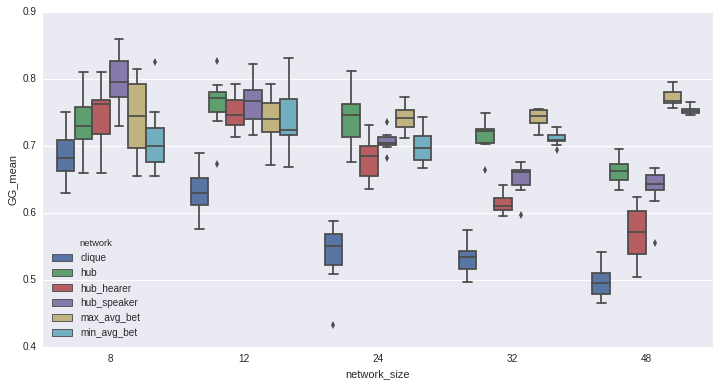

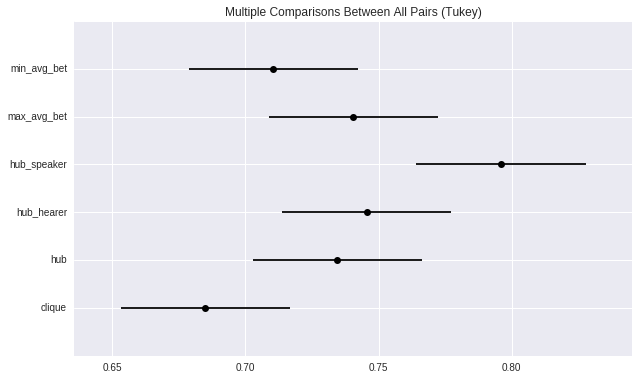

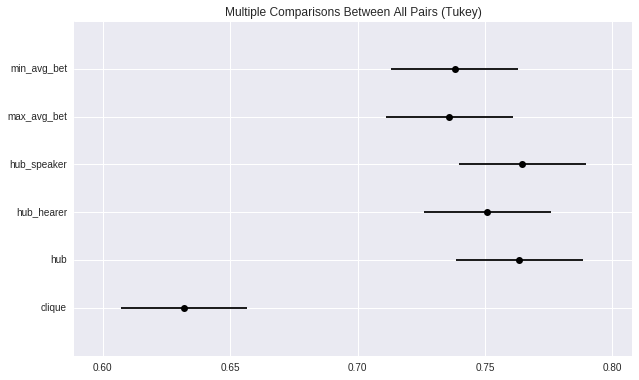

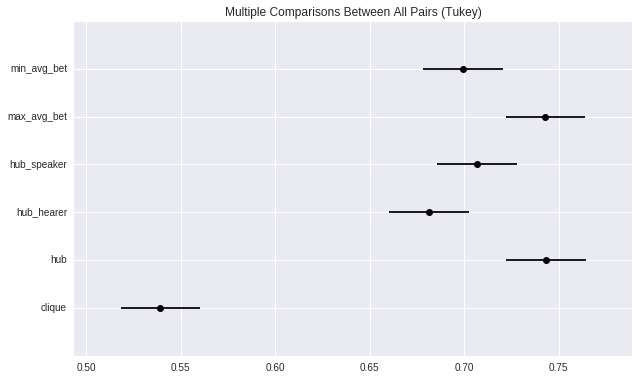

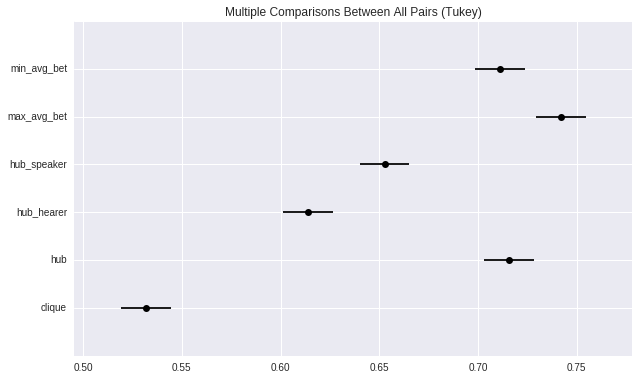

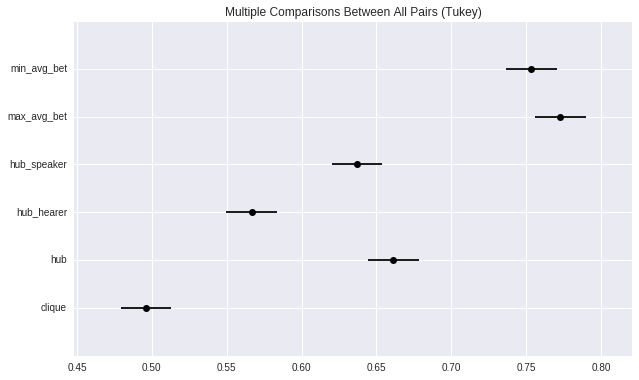

In [9]:
do_anal(p1_CSL, 'GG_mean')

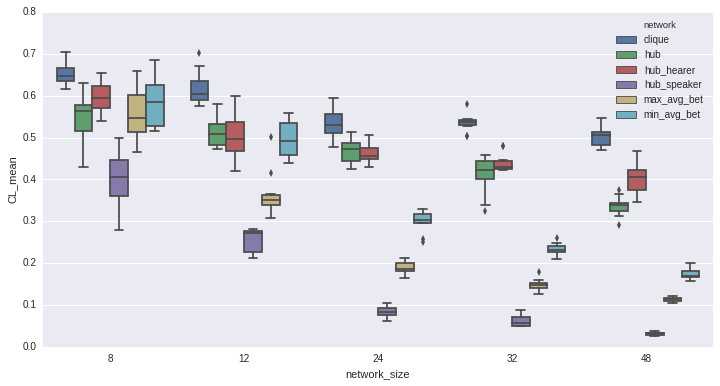

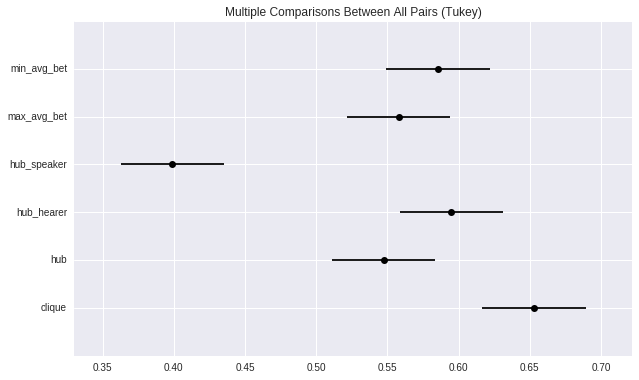

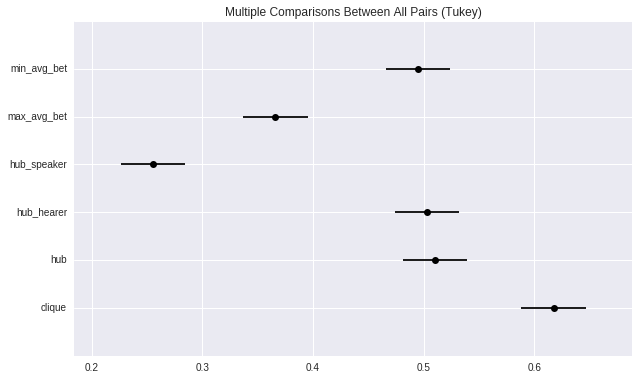

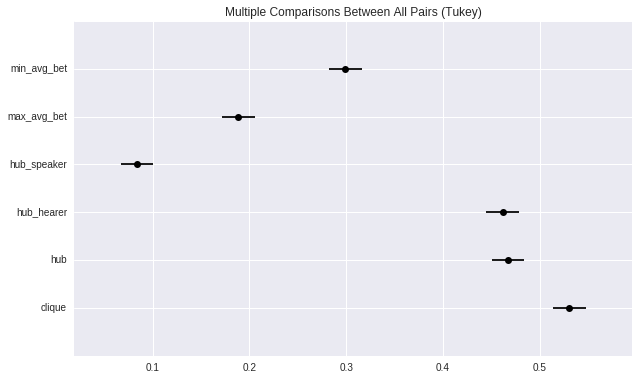

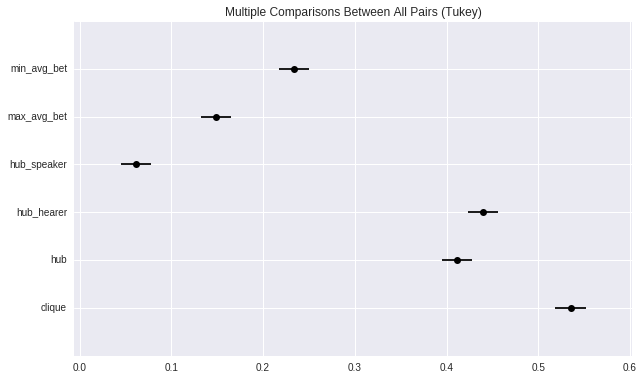

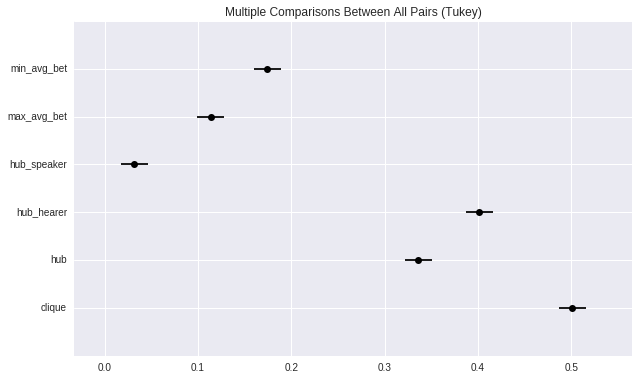

In [10]:
do_anal(p1_CSG, 'CL_mean')

## Topology shift

In [11]:
df = top_shift
ts_CSL = df[df.it2==phase2][cols + ['GG_mean']]
ts_CSG = df[df.it2==phase2][cols + ['CL_mean']]

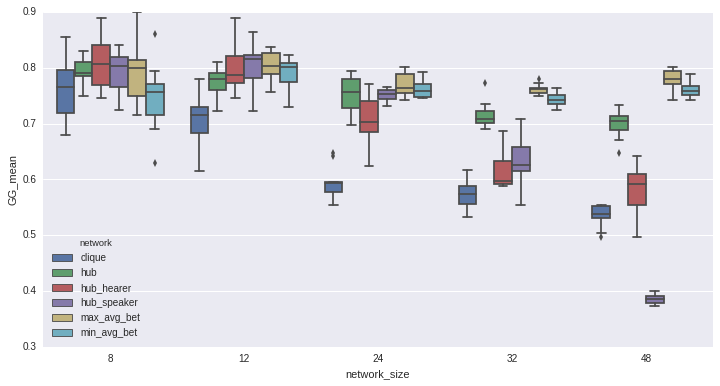

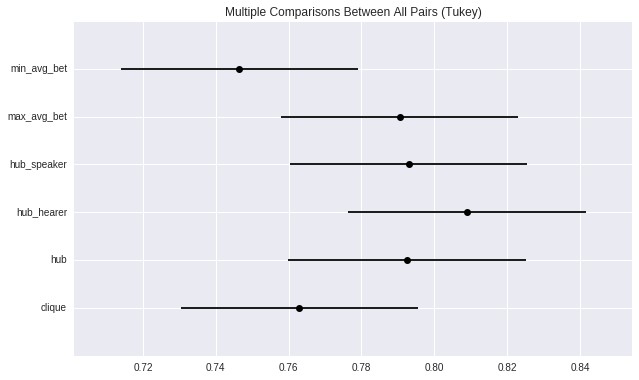

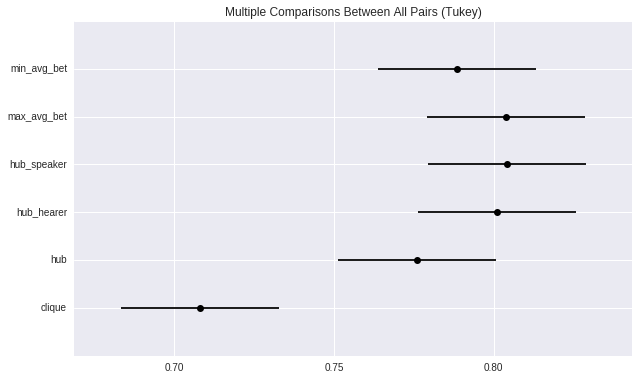

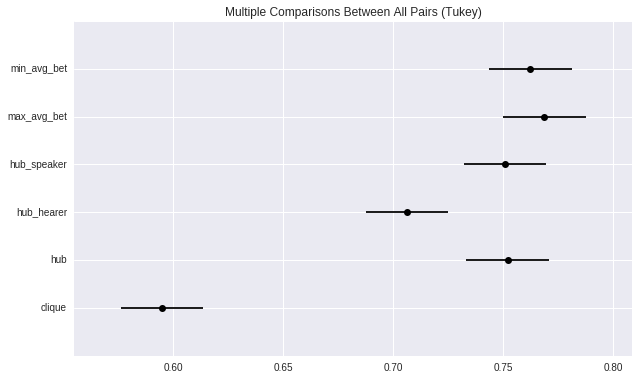

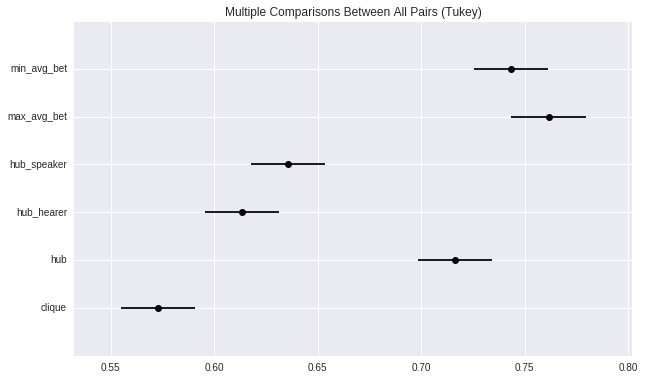

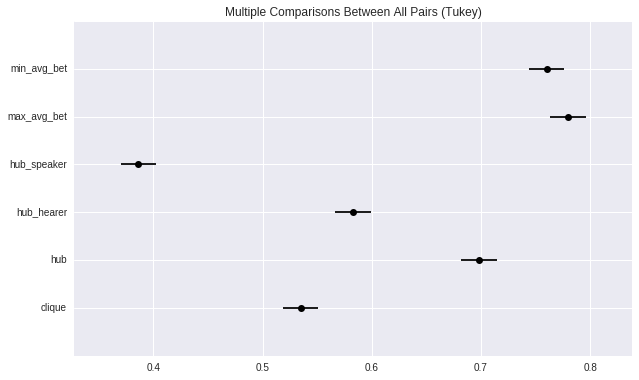

In [12]:
do_anal(ts_CSL, 'GG_mean')

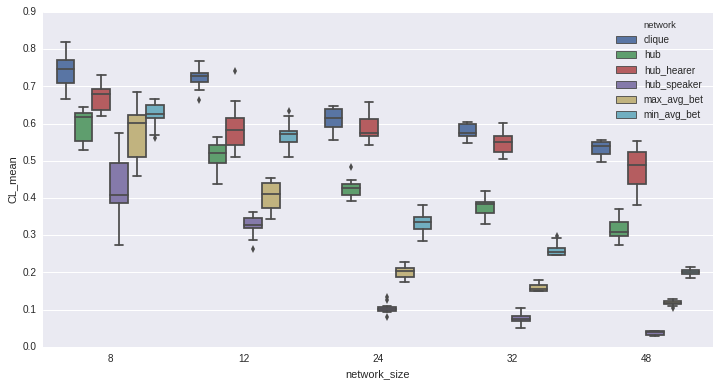

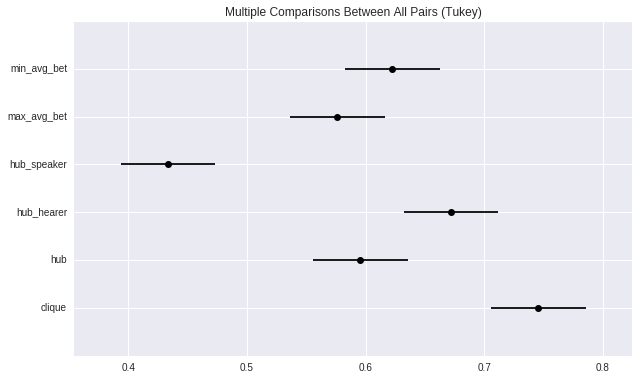

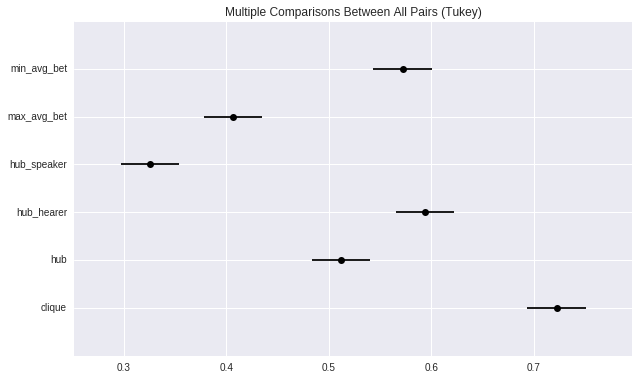

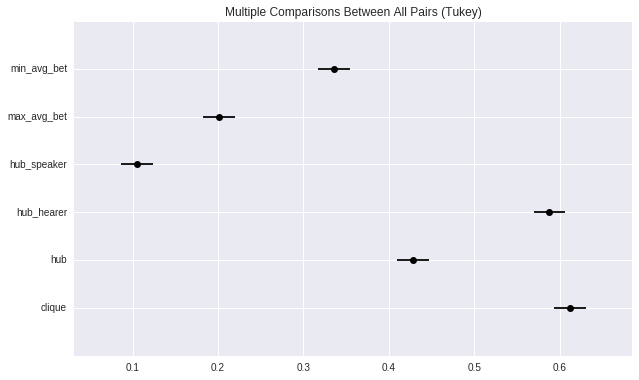

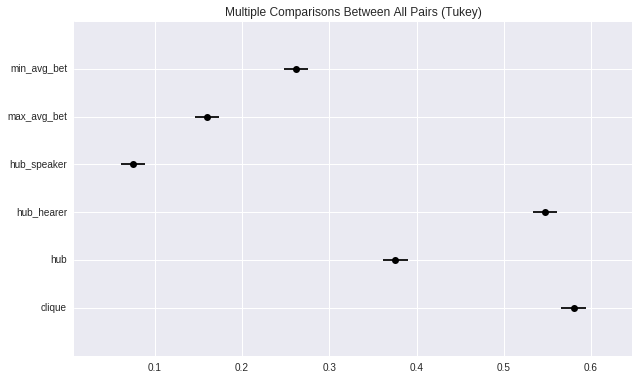

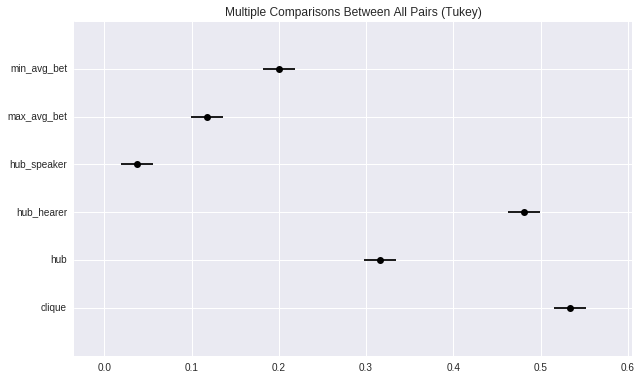

In [13]:
do_anal(ts_CSG, 'CL_mean')

## Environment shift

In [14]:
df = env_shift
es_CSL = df[df.it2==phase2][cols + ['GG_mean']]
es_CSG = df[df.it2==phase2][cols + ['CL_mean']]

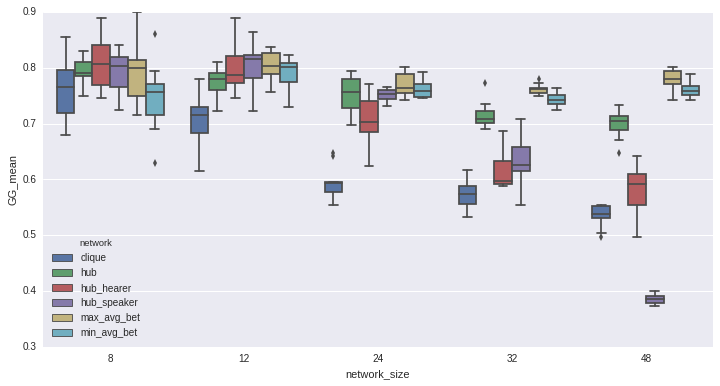

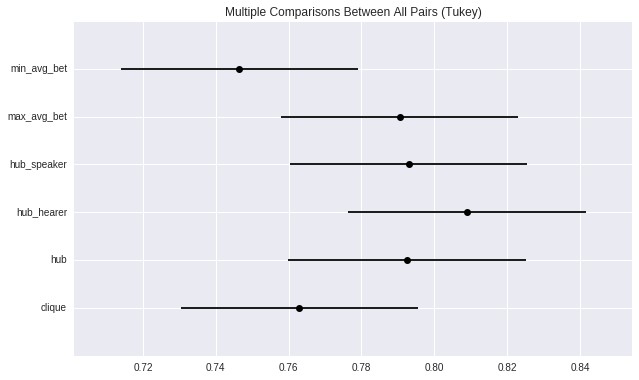

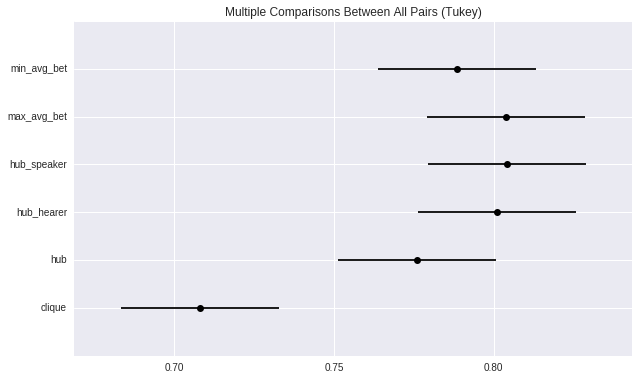

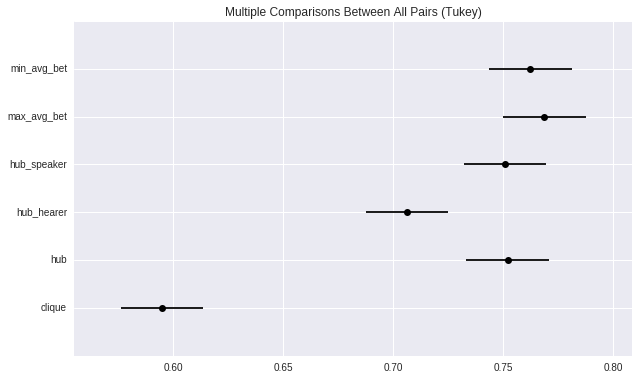

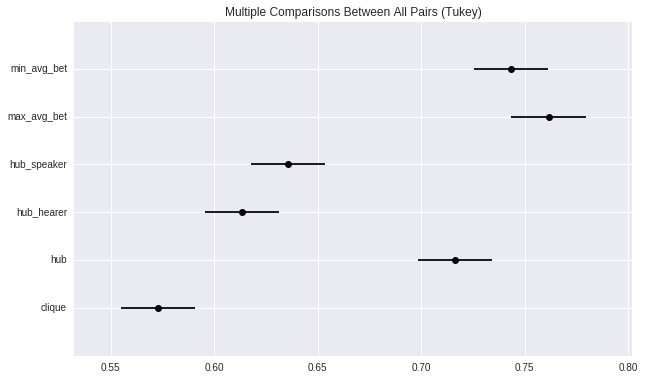

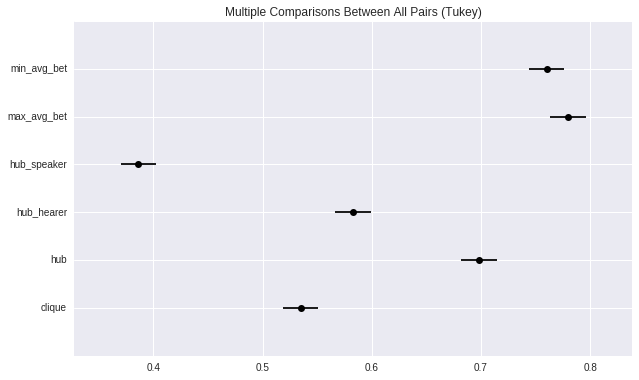

In [15]:
do_anal(ts_CSL, 'GG_mean')

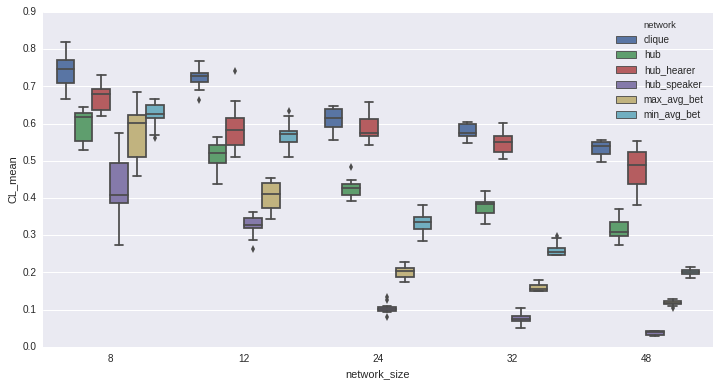

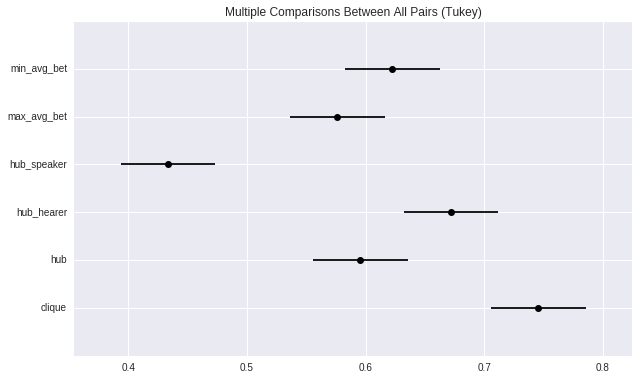

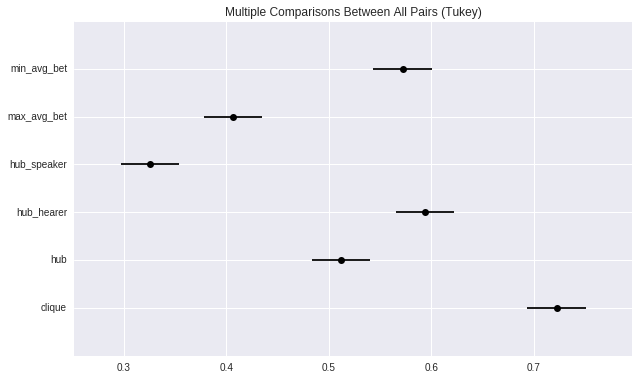

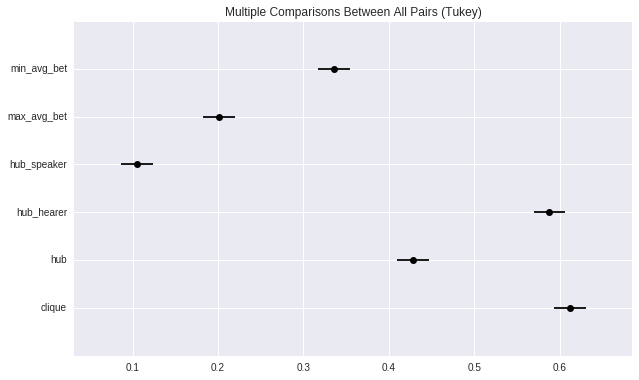

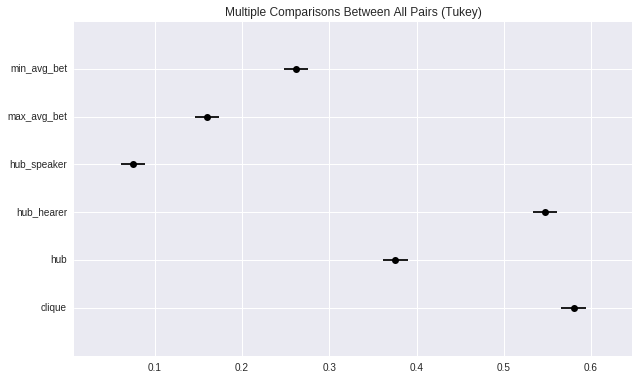

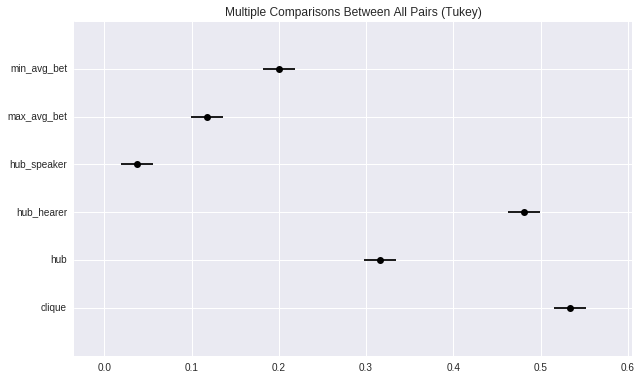

In [16]:
do_anal(ts_CSG, 'CL_mean')